Visualize multiple gels by plotting their 2D projections

In [11]:
import sys

sys.path.append("../")

In [12]:
import json

from pathlib import Path
from typing import Any

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


from config import Config

## Plot the farthest gel of each seed

In [13]:
def extract_timestep(p: Path) -> int:
    return int(p.stem.split("_")[-1])

def get_pos_files(gel_dir_path: Path) -> dict[str, Any]:
    all_pos_files = sorted(
        (gel_dir_path / "raw/gel_eq").glob("*.npy"), key=extract_timestep)
    if len(all_pos_files) == 0:
        return {}
    pos_file = all_pos_files[-1]
    timestep = extract_timestep(pos_file)
    config = Config.from_file(gel_dir_path / "config.json")
    return {"path": pos_file, "timestep": timestep,
                       "forcefield": config.agent_force_field, "seed": config.seed, "box_l": config.initial_box_l}

# gel_dirs = list((Path().home() / "data/mmgel/production4").iterdir())
gel_dirs = list(Path("../../data/raw/13112024_new_crosslinking_agents=crosslinks/").iterdir())
len(gel_dirs)

184

In [14]:
sample_config = json.loads((gel_dirs[0] / "config.json").read_text())
sample_config

{'new_rng_state': False,
 'seed': 16038743,
 'n_chains': 70,
 'chain_length': 60,
 'charge_per_bead': 0.15,
 'steps_melt_eq_max': 1000,
 'steps_per_cl_iteration': 1,
 'steps_gel_eq_max': 3000000,
 'steps_mmgel_eq_max': 3000000,
 'volume_fraction': 0.3,
 'crosslink_percentage': 0.7,
 'agent_force_field': 'none',
 'n_agents_per_crosslink': 2.0,
 'initial_diff_steps': 1,
 'bond_type': 'fene',
 'mnp_volume_fraction': 0.075,
 'mnp_charge': 14.0,
 'strict_mnp_count': False}

In [15]:
# only take gel dirs which have data
pos_df = pd.DataFrame.from_records(filter(lambda d: len(d) != 0, [get_pos_files(gel_dir) for gel_dir in gel_dirs]))
pos_df.sort_values(by="timestep")

,path,timestep,forcefield,seed,box_l
0,../../data/raw/13112024_new_crosslinking_agent...,315000,harmonic,38508250,101.4
3,../../data/raw/13112024_new_crosslinking_agent...,320000,none,30460241,101.4
1,../../data/raw/13112024_new_crosslinking_agent...,325000,harmonic,80978228,101.4
2,../../data/raw/13112024_new_crosslinking_agent...,325000,none,72929352,101.4


In [16]:
pos_df.sort_values(by="timestep").iloc[-1]["path"]

PosixPath('../../data/raw/13112024_new_crosslinking_agents=crosslinks/run=0_seed=11389651_ff=none_charge=0.05_vf=0.45_crosslink=0.2/raw/gel_eq/BeadPos_325000.npy')

In [17]:
pos_df['timestep'].max()

325000

In [18]:
def plot_gels(df, bead_step=1, with_box=False):
    """Plot all gels in the dataframe"""
    ncols = 3
    nrows = max(len(grouped_df) for _, grouped_df in df.groupby("forcefield"))
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*6, nrows*6))
    for col, (force_field, grouped_df) in enumerate(df.groupby("forcefield")):
        for row, (df_index, atom_df) in enumerate(grouped_df.iterrows()):
            ax = axs[row, col]
            points = np.load(atom_df["path"])[::bead_step]
            ax.plot(*points[:, :2].T, ".")
            box_l = atom_df["box_l"]
            if with_box:
                ax.hlines([0, box_l], 0, box_l, color="k")
                ax.vlines([0, box_l], 0, box_l, color="k")
            ax.set_aspect("equal")
            ax.set_title(f"{100*atom_df['timestep'] / sample_config['steps_gel_eq_max']:.1f}% | {atom_df['seed']}, {force_field}")
    plt.show()

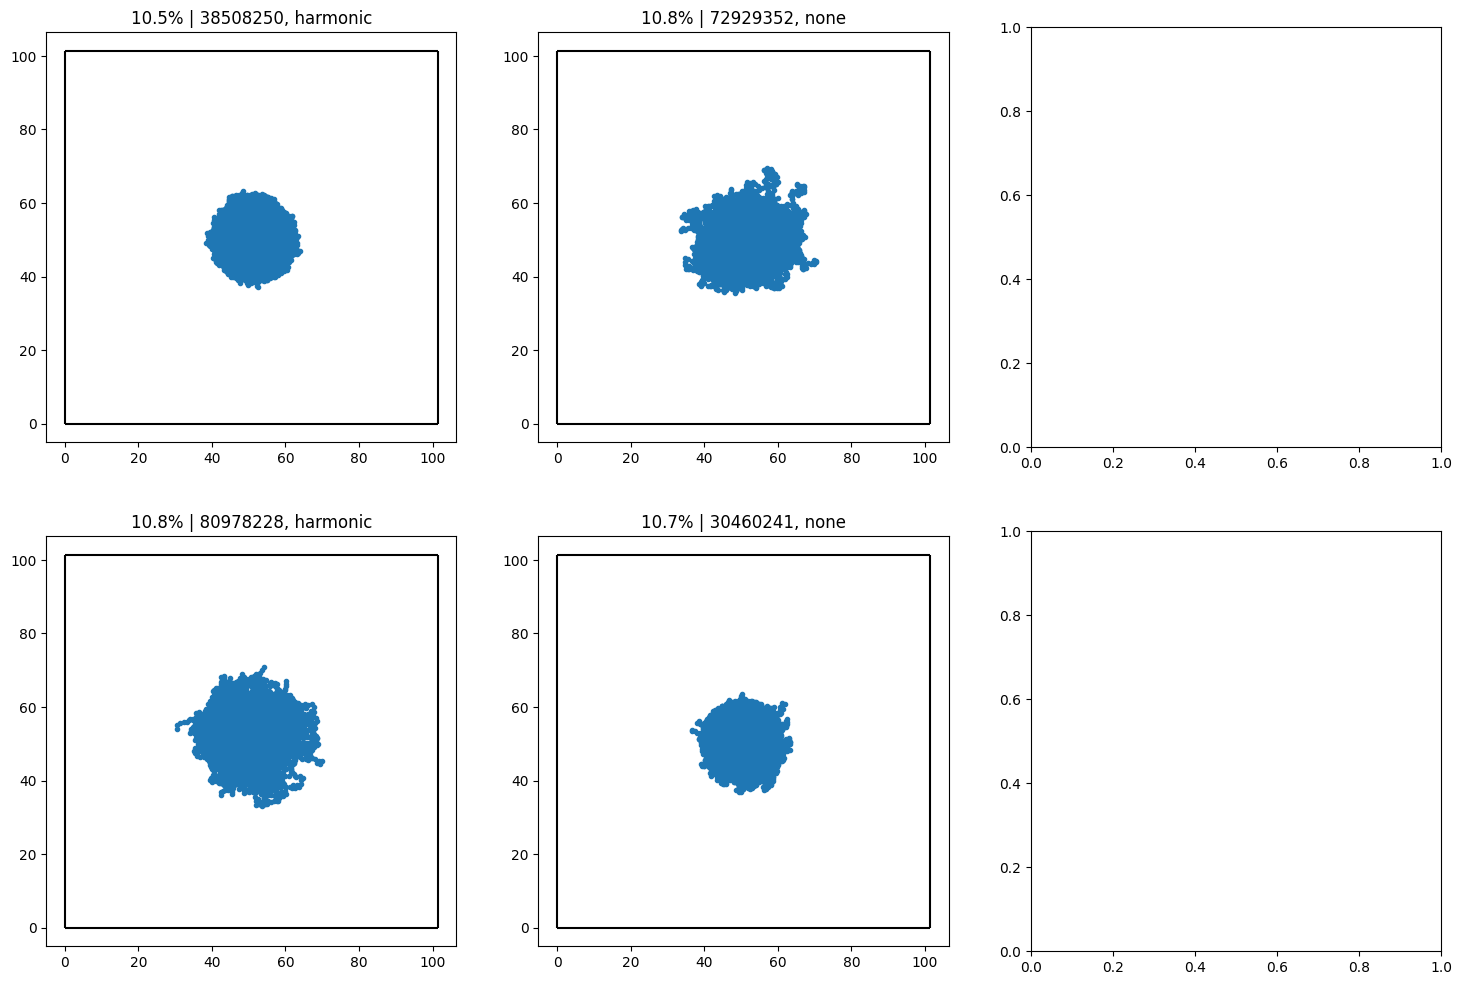

In [19]:
plot_gels(pos_df, bead_step=1, with_box=True)

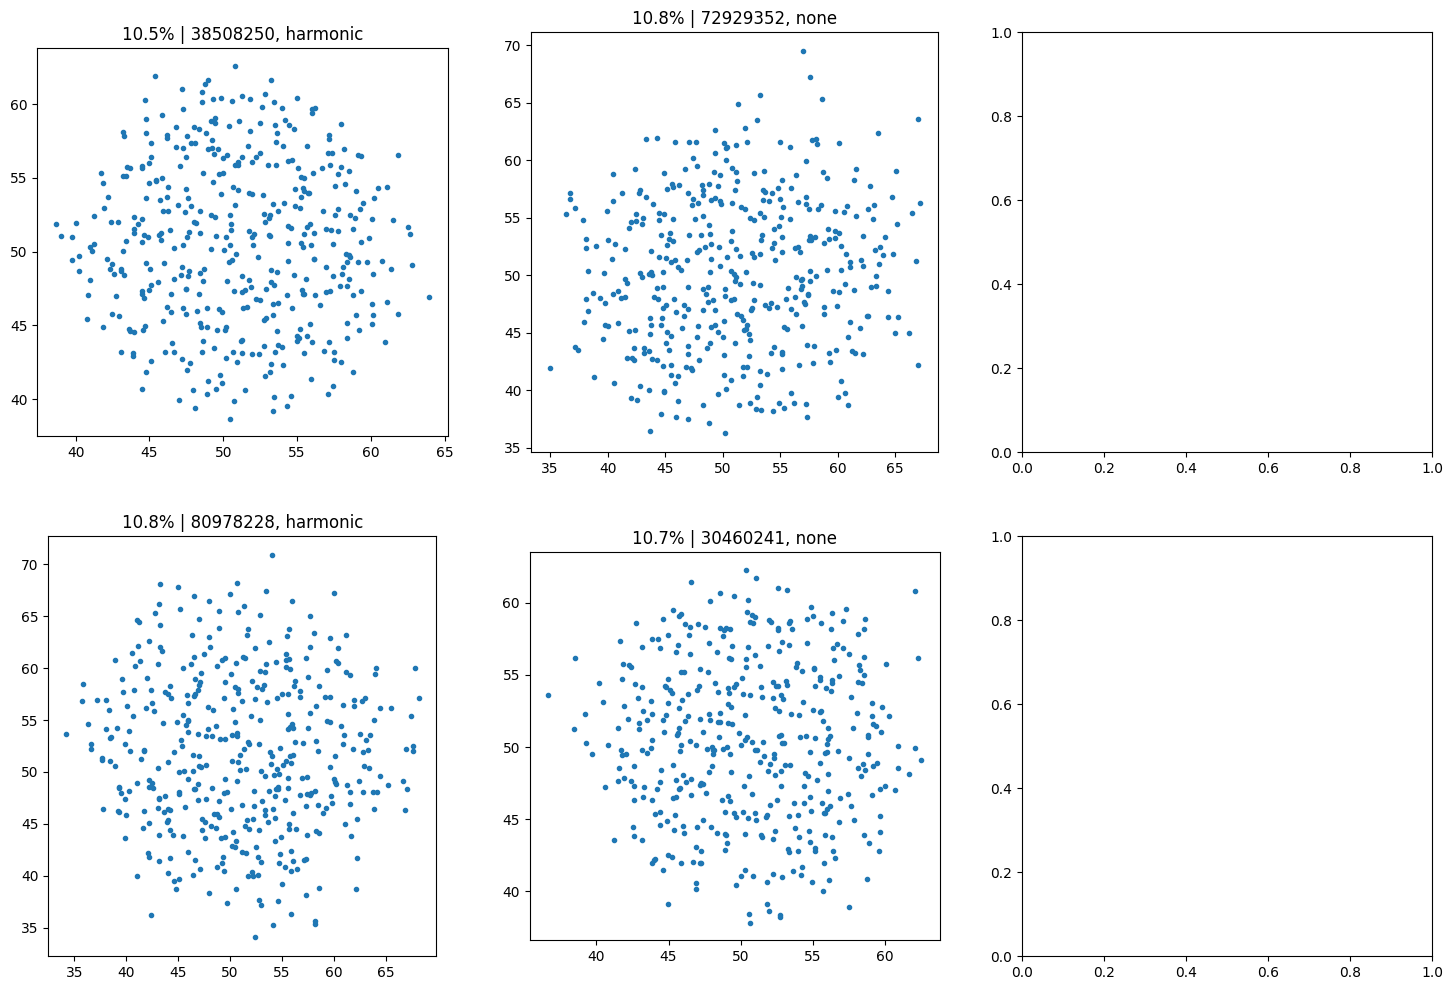

In [20]:
plot_gels(pos_df, bead_step=10)

In [21]:
bead_pos_path = pos_df.sort_values(by="timestep").iloc[-1].path
bead_pos_path

PosixPath('../../data/raw/13112024_new_crosslinking_agents=crosslinks/run=0_seed=11389651_ff=none_charge=0.05_vf=0.45_crosslink=0.2/raw/gel_eq/BeadPos_325000.npy')

In [22]:
gel_dir_path = bead_pos_path.parent.parent.parent
gel_dir_path

PosixPath('../../data/raw/13112024_new_crosslinking_agents=crosslinks/run=0_seed=11389651_ff=none_charge=0.05_vf=0.45_crosslink=0.2')

In [23]:
bead_pos = np.load(bead_pos_path)
bead_pos.shape

(4200, 3)

In [24]:
checkpoint_paths = sorted((gel_dir_path / "checkpoints").glob("GelEq_*"), key=lambda p: int(p.name.split("_")[-1]))
checkpoint_paths[:3]

[PosixPath('../../data/raw/13112024_new_crosslinking_agents=crosslinks/run=0_seed=11389651_ff=none_charge=0.05_vf=0.45_crosslink=0.2/checkpoints/GelEq_50000'),
 PosixPath('../../data/raw/13112024_new_crosslinking_agents=crosslinks/run=0_seed=11389651_ff=none_charge=0.05_vf=0.45_crosslink=0.2/checkpoints/GelEq_100000'),
 PosixPath('../../data/raw/13112024_new_crosslinking_agents=crosslinks/run=0_seed=11389651_ff=none_charge=0.05_vf=0.45_crosslink=0.2/checkpoints/GelEq_150000')]

In [25]:
crosslink_ids = np.load(checkpoint_paths[-1] / "crosslinks.npy")
crosslink_ids.shape

(513, 2)

In [26]:
crosslink_ids.min(), crosslink_ids.max()

(4, 4196)

In [27]:
bead_pos

array([[55.147536  , 41.84104703, 54.48472803],
       [54.52659619, 42.18220662, 55.21164039],
       [54.96679431, 42.99318924, 55.50460907],
       ...,
       [47.02927294, 43.91343457, 45.58613492],
       [48.0345668 , 43.92135153, 45.70073312],
       [48.42641882, 44.76503762, 45.37268389]])

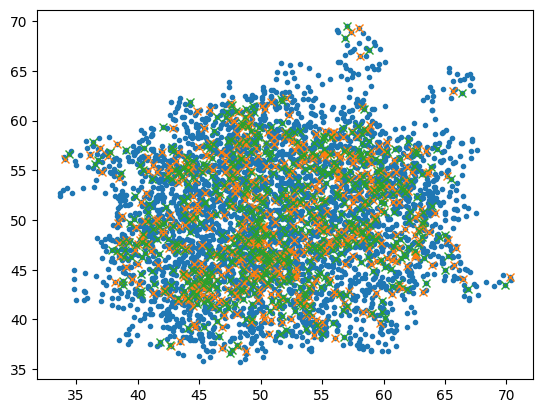

In [28]:
plt.plot(*bead_pos[:, :2].T, ".")
plt.plot(*bead_pos[crosslink_ids[:, 0], :2].T, "x")
plt.plot(*bead_pos[crosslink_ids[:, 1], :2].T, "x")
plt.show()

In [29]:
crosslink_pos = np.vstack([bead_pos[crosslink_ids[:, 0], :2], bead_pos[crosslink_ids[:, 1], :2]])
crosslink_pos.shape

(1026, 2)

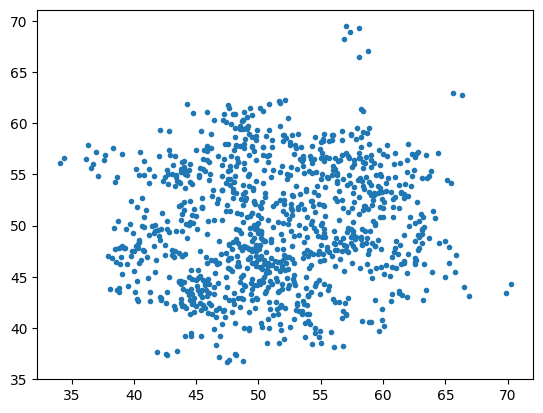

In [30]:
plt.plot(*crosslink_pos.T, ".")
plt.show()

In [31]:
from typing import Optional
from scipy import spatial

def sphere_volume(radius):
    return (4/3) * np.pi * np.power(radius, 3)


def radial_distribution_function(points: np.ndarray,
                                 pointsB: Optional[np.ndarray] = None,
                                 points_intersect: bool = False,
                                 **hist_kwargs) -> pd.DataFrame:
    if pointsB is None:
        distances = spatial.distance.pdist(points, metric="euclidean")
    else:
        distances = spatial.distance.cdist(
            points, pointsB, metric="euclidean").flatten()
        if points_intersect:
            is_separate = distances > 1e-15
            distances = distances[is_separate]

    count, bin_edges = np.histogram(
        distances,
        bins=hist_kwargs.get("bins", "auto"),
        range=(0, distances.max()),
    )

    # Normalization
    volume = sphere_volume(radius=bin_edges[-1])
    bin_volumes = 4./3. * np.pi * (bin_edges[1:]**3 - bin_edges[:-1]**3)
    rdf = volume / len(distances) * count / bin_volumes

    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    return pd.DataFrame({
        "r": bin_centers,
        "rdf": rdf,
    })

          r        rdf
0  0.016467  20.020020
1  0.049401  16.945517
2  0.082335  16.661398
3  0.115268  15.623732
4  0.148202  14.567847


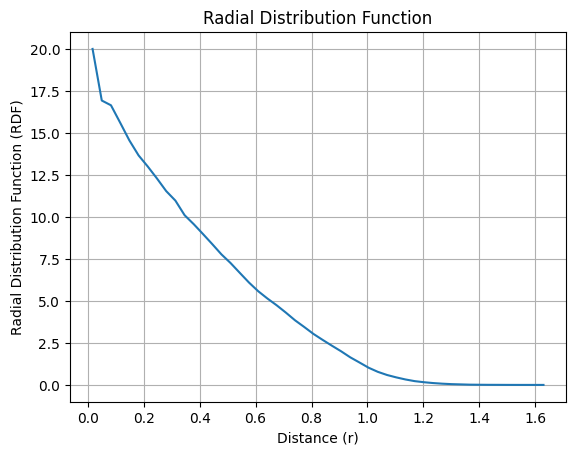

In [32]:
# Generate random points in 3D space
n_points = 1000
points = np.random.random((n_points, 3))  # 1000 random points in a unit cube

# Compute the radial distribution function
rdf_df = radial_distribution_function(points, bins=50)

# Inspect the resulting DataFrame
print(rdf_df.head())

# Plot the RDF
plt.plot(rdf_df["r"], rdf_df["rdf"])
plt.xlabel('Distance (r)')
plt.ylabel('Radial Distribution Function (RDF)')
plt.title('Radial Distribution Function')
plt.grid(True)
plt.show()

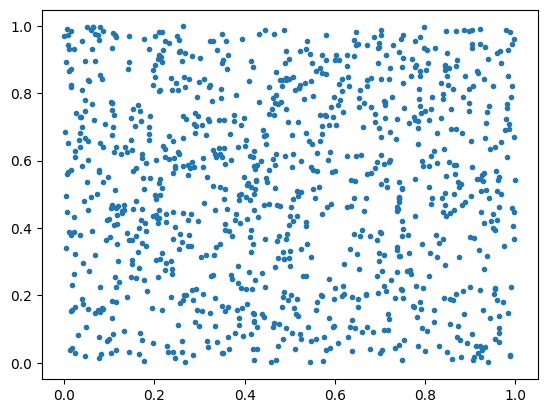

In [33]:
plt.plot(*points[:, :2].T, ".")
plt.show()

In [ ]:
p = np.load("/home/username/software/mmgel_git/test12345678.npy")
p.shape

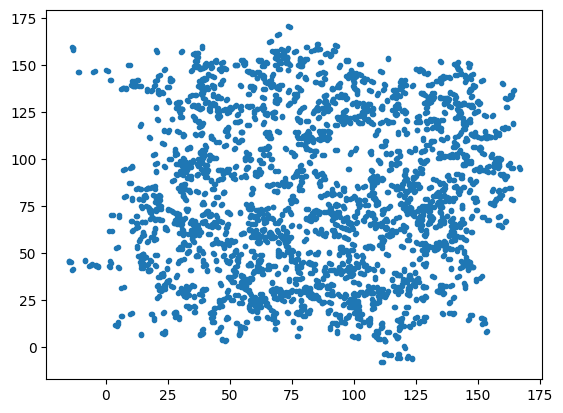

In [ ]:
plt.plot(*p[:, :2].T, ".")
plt.show()